# Time Series Classification using Dynamic Time Warping (DWT)

The goal is to train a model that can accurately predict the class of a time series given a dataset with labeled time series sequences. 

A popular way to do this is to use the K-Nearest Neighbors algorithm, but instead of using the classic euclidean distance, the implementation is adapted to utilize the Dynamic Time Warping metric. DWT takes into consideration the fact that the two time series being compared may vary in lenght and speed. 

This approach, while simple and efficient in practice, is in fact quite elusive, something which is mainly attributed to the DTW. The most common beginner mistake is to perform hyperparameter tunning on the KNN and completly overlook the DTW part. The main disadvantage of DTW is time complexity: for large datasets with lenghty sequences, it may b impossible to train the model in reasonable time. Fortunately, by understanding the underlying of DTW, it is possible to perform the necessary tweaks in order to significantly speed up the algorithm. 

## DTW: How it works:

Essentially, DTW is a dynamic programming algorithm. These algorithm breaks the problem recursively into subproblems, store the results, and later use those results when needed, instead of recomputing them.

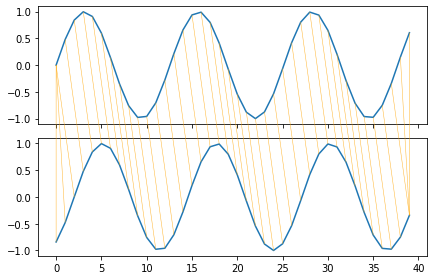

In [1]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np


x = np.arange(0,20,.5)
s1 = np.sin(x)
s2 = np.sin(x-1)
path = dtw.warping_path(s1,s2)
dtwvis.plot_warping(s1,s2,path)
distance = dtw.distance(s1,s2)

In [2]:
distance

1.4419019877541719

As we can see, the time complexity of the algorithm is quadratic: O(N*M), where M and N are the lenghts of the respectives sequences. Considering that this sequences might be pretty large, and the fact that KNN has to run afterwards, it's very likely that the model may take to long to get trained. 

Fortunately, now that we know how DTW works as well as the context of the problem, it is posible to optimize the total execution. On key observation is that most of the time, the optimal time warping follow the main diagonal. As part of dataset exploration, one could also extract important features with Fourier Transform and make sure there is not problem. 

We can achive this by using the window argument, also add *use_pruning=True*

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

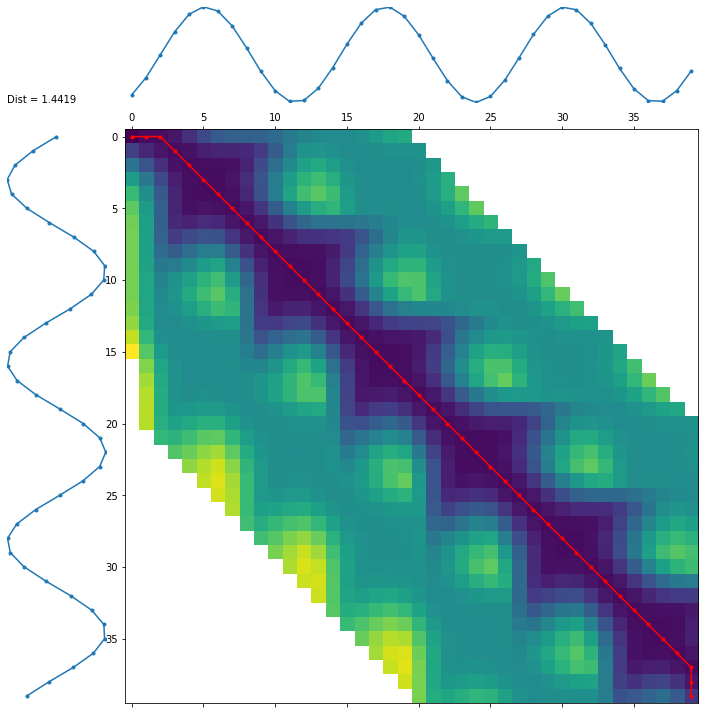

In [3]:
d, paths = dtw.warping_paths(s1,s2,window=20,use_pruning=True)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1,s2,paths,best_path)

## Real case scenario

In [4]:
x_train_file = open(r'UCI HAR Dataset/train/X_train.txt','r')
y_train_file = open(r'UCI HAR Dataset/train/y_train.txt','r')

x_test_file = open(r'UCI HAR Dataset/test/X_test.txt','r')
y_test_file = open(r'UCI HAR Dataset/test/y_test.txt','r')

x_train = []
y_train = []
x_test = []
y_test = []

#Mapping table for classes:
labels = {1:'WALKING',2:'WALKING UPSTAIRS',3:'WALKING DOWNSTAIRS',
          4: 'SITTING',5:'STANDING',6:'LAYING'}

for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append([float(ts) for ts in y.split()])
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append([float(ts) for ts in y.split()])
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD',
          '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

In [5]:
x_train

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [8]:
%%time
idx=0
for r in range(len(x_test)):
    distances=dtw.distance(x_train[idx], x_test[r],window=20,use_pruning=True)

CPU times: user 3min 11s, sys: 130 ms, total: 3min 11s
Wall time: 3min 11s


In [7]:
%%time
idx=0
for r in range(len(x_test)):
    distance=dtw.distance(x_train[idx], x_test[r])

CPU times: user 51min 37s, sys: 3.31 s, total: 51min 40s
Wall time: 51min 42s


It is considerably faster. Finally we conclude by applying the KNN algorithm:

In [9]:
# function that takes as input the number of neigbors of KNN and the # index of the time series in the test set, and returns one of the 
# labels: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, 
# STANDING, LAYING
def classifyNN(k:int, idx:int) -> str:
    
    idxs=range(0,x_train.shape[0])
    n=x_train.shape[0]
    distances=[]
    counters={}
    c=1;
    max_value=0
    for r in range(n):
            distances.append(dtw.distance(x_test[idx], x_train[idxs[r]],window=10,use_pruning=True))
    NN=sorted(range(len(distances)), key=lambda i: distances[i], reverse=False)[:k]
    
    for l in labels.values():
        counters[l]=0
    for r in NN:
        l=labels[y_train[r]]
        counters[l]+=1
        if (counters[l])>max_value:
            max_value=counters[l]
        #print('NN(%d) has label %s' % (c,l))
        c+=1
    
    # find the label(s) with the highest frequency
    keys = [k for k in counters if counters[k] == max_value]
    
    # in case of a tie, return one at random
    return (sample(keys,1)[0])